In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'
from utils import *

In [2]:
def get_idx(dd, cond):
    return dd.query(cond).index.tolist()

def drop_untrained(dd, th=0.01, verbose=False):
    tmax = dd['t'].max()
    ii = get_idx(dd, f"t == {tmax} & err > {th}")
    iis = [j for i in ii for j in range(i-tmax, i+1, 1)]
    if verbose:
        print(len(ii))
        print(dd[['m', 'opt', 'bn', 'seed']].iloc[ii])
    return dd.drop(iis)

In [30]:
def avg_model(d, groupby=['m', 't'], probs=False, avg=None, get_err=True, compute_distance=False, dev='cuda', distf=th.cdist):
    key = ['yh', 'yvh']
    n_data = d[key].iloc[0].shape[0]
    
    if avg is None:
        avg = {}
        if not probs:
            for k in key:
                d[k] = d.apply(lambda r: np.exp(r[k].flatten().numpy()), axis=1)

        avg = d.groupby(groupby)[key].mean(numeric_only=False).reset_index()
    
    if get_err:
        for k in key:
            ykey = k.strip("h")
            y = get_data(dev='cuda')[ykey]
            n = len(y)
            preds = np.argmax(np.stack(avg[k]).reshape(-1, n , 10), -1)
            err =  ((th.Tensor(preds).cuda() != y).sum(1) / n).cpu().numpy()
            avg[f'{ykey[1:]}err'] = err
    
    if compute_distance:
        dists = []
        for i in range(len(avg)):
            config = {}
            for k in groupby:
                v = avg.iloc[i][k]
                if isinstance(v, str):
                    v = f"'{v}'"
                config[k] = v
            ii = get_idx(d, "&".join([f"{k} == {v}" for (k, v) in config.items()]))
            
            for k in key:
                x1 = avg.iloc[i][k].reshape(1, -1, 10)
                x2 = np.stack(d.loc[ii][k]).reshape(len(ii), -1, 10)
                x1 = th.Tensor(x1).transpose(0, 1).to(dev)
                x2 = th.Tensor(x2).transpose(0, 1).to(dev)
#                 dist = -th.log(th.bmm(x2, x1.transpose(1,2))).mean(0)
                dist = distf(x2, x1).mean(0)
                for (j, dj) in enumerate(dist):
                    dic = dict(dist=dj.item(), key=k)
                    for (kc, vc) in config.items():
                        if isinstance(vc, str):
                            vc = vc.strip("''")
                        dic.update({kc:vc})
#                     dic.update(config)
                    dists.append(dic)
        dists = pd.DataFrame(dists)
        return avg, dists
    return avg

In [4]:
loc = 'results/models/new'
# d = pd.read_pickle(os.path.join(loc, "avg_models.pkl"))
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0})
d_ = drop_untrained(d, 0.01, False).reset_index()
del d

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 3600


In [13]:
bdist = lambda x1, x2: th.sqrt(-th.log(th.bmm(th.sqrt(x1), th.sqrt(x2).transpose(1, 2))))

In [14]:
avg, dists = avg_model(d_, groupby=['m', 'opt', 'bn', 't'], probs=True, get_err=True, 
                       compute_distance=True, distf=bdist, dev='cuda')

In [15]:
dists

,dist,key,m,opt,bn,t
0,0.066084,yh,allcnn-96-144,adam,True,0
1,0.188333,yh,allcnn-96-144,adam,True,0
2,0.025066,yh,allcnn-96-144,adam,True,0
3,0.275795,yh,allcnn-96-144,adam,True,0
4,0.083347,yh,allcnn-96-144,adam,True,0
...,...,...,...,...,...,...
5595,0.081896,yvh,wr-4-8,sgdn,True,19
5596,0.081650,yvh,wr-4-8,sgdn,True,19
5597,0.083180,yvh,wr-4-8,sgdn,True,19
5598,0.083591,yvh,wr-4-8,sgdn,True,19


In [19]:
models = ["'wr-4-8'", "'allcnn-96-144'", "'fc-1024-512-256-128'"]
opts = ["'adam'", "'sgdn'", "'sgd'"]
bns = [False, True]
mdict = {m.strip("''"):i for (i, m) in enumerate(models)}
odict = {o.strip("''"):i for (i, o) in enumerate(opts)}

In [71]:
cond = "opt == 'adam'& t == 0&bn==True&m=='wr-4-8'"
allm = np.stack(d_.iloc[get_idx(d_, cond)]['yh'])
am = np.stack(avg.iloc[get_idx(avg, cond)]['yh'])

In [97]:
T = 45000
ts = []
for t in range(T):
    if t < T//10:
        if t % (T//100) == 0:
            ts.append(t)
    else:
        if t%(T//10) == 0 or (t == T-1):
            ts.append(t)
tmap = {i:t for (i, t) in enumerate(ts)}

In [98]:
d_['t'] = d_['t'].map(tmap)
dists['t'] = dists['t'].map(tmap)
avg['t'] = avg['t'].map(tmap)

### Distance from averaged model
Model 0 is saved after first optimization step, which might explain the larger distance of adam at t=0

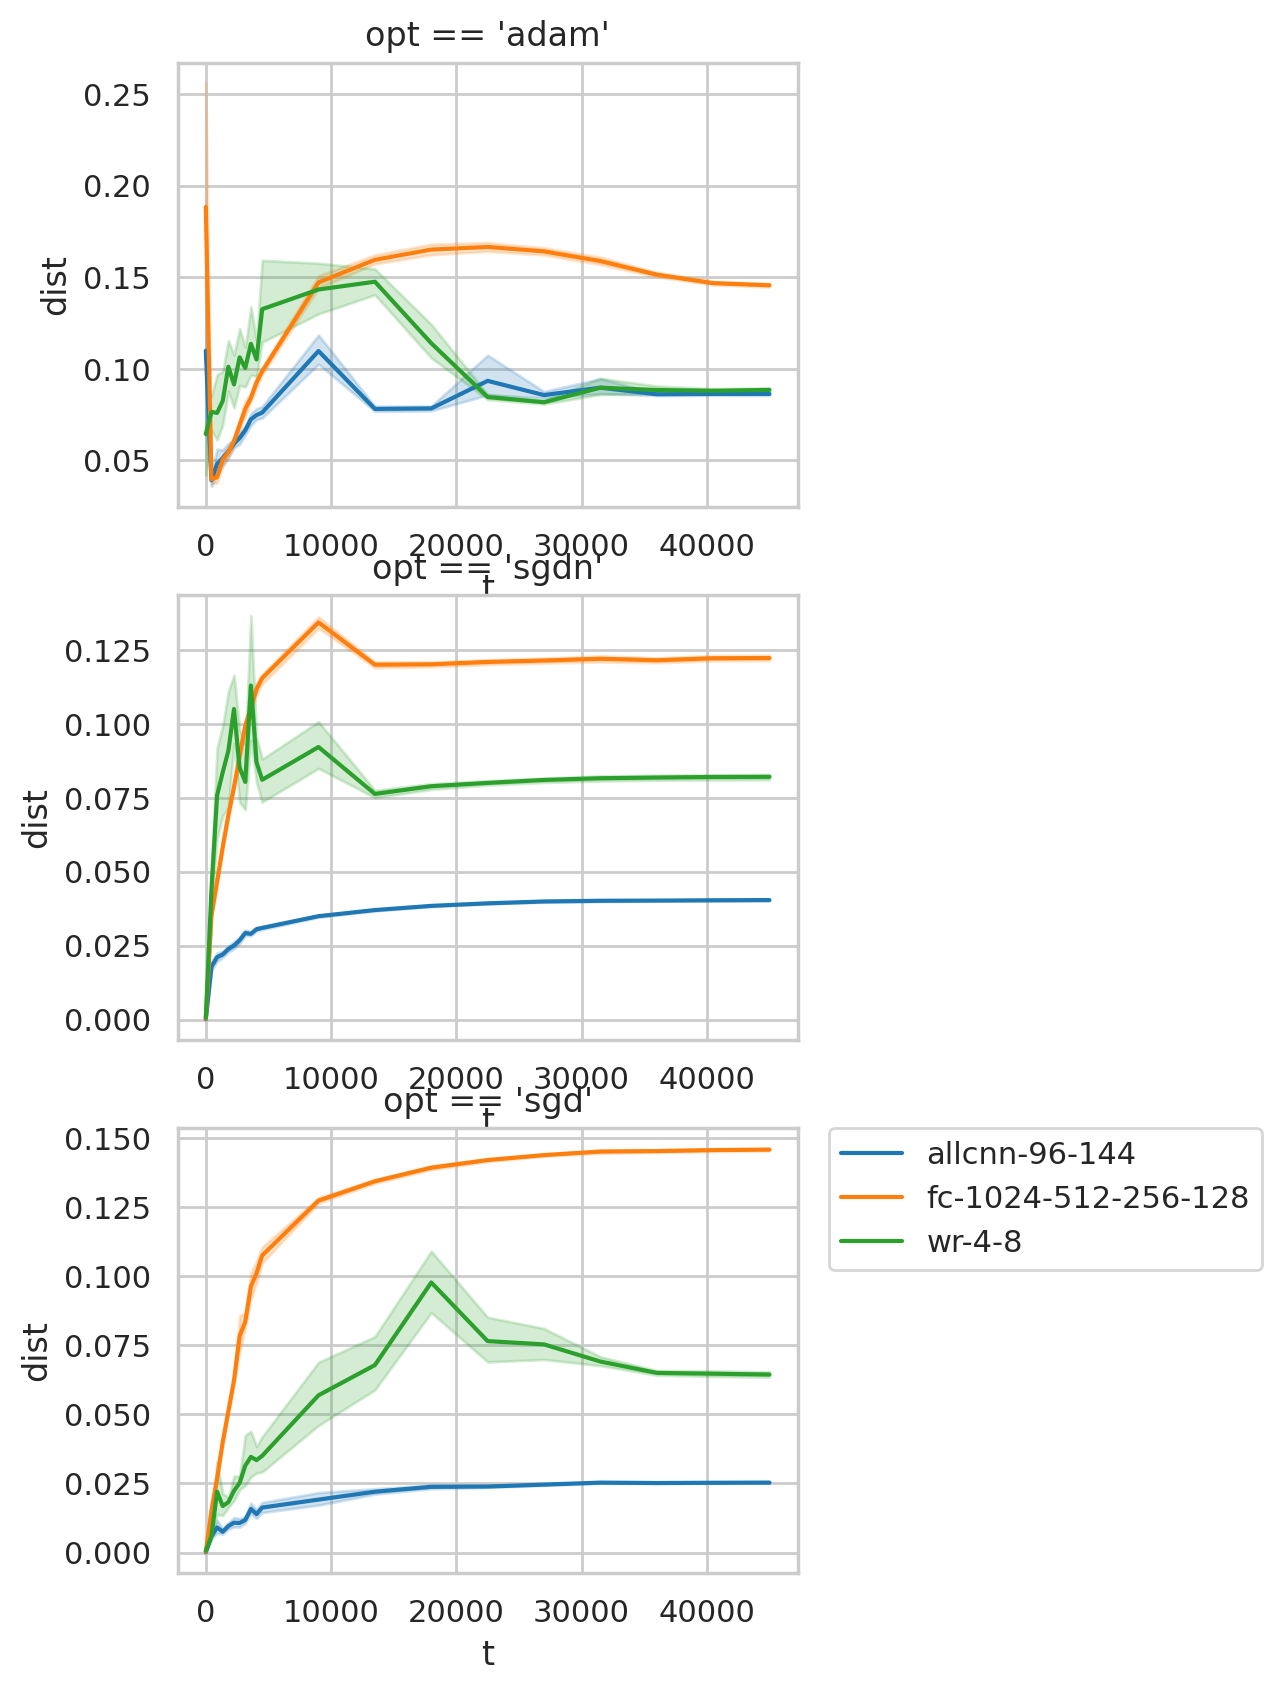

In [12]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
leg = None
for (i,opt) in enumerate(opts):
    if leg:
        leg.remove()
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yvh' & bn == True & opt == {opt}")],
             x='t', y='dist', hue='m', ax=axes[i])
    axes[i].set_title(f"opt == {opt}")
    leg = axes[i].get_legend()
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


<AxesSubplot:xlabel='t', ylabel='vfavg'>

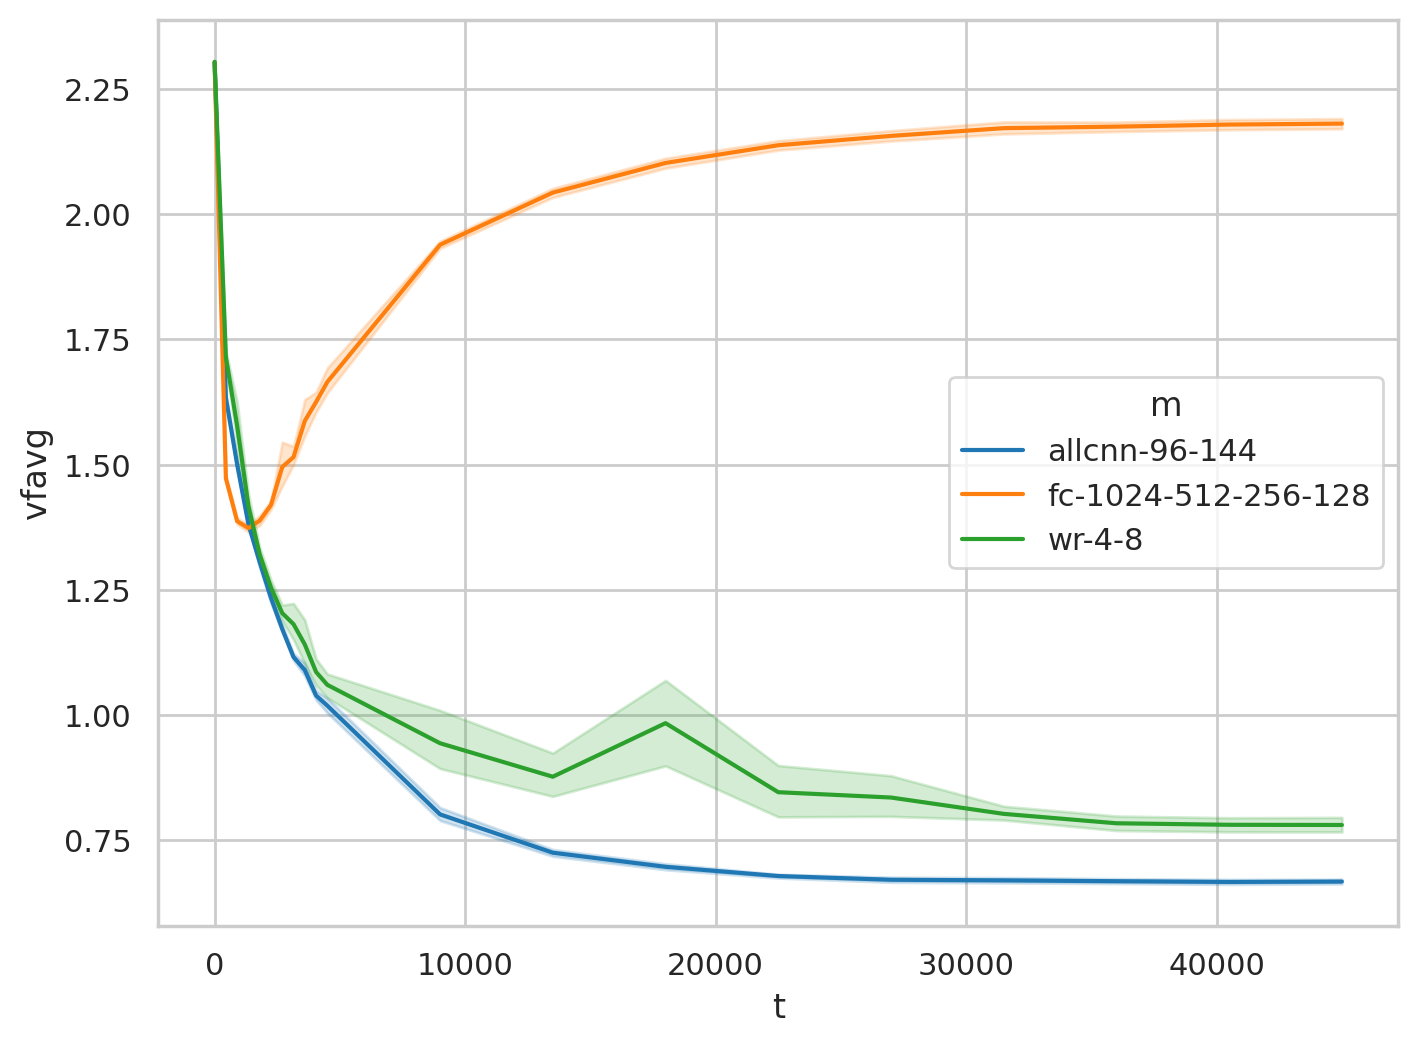

In [111]:
sns.lineplot(data=d_.iloc[get_idx(d_, f" bn == True & opt == 'sgd'")],
             x='t', y='vfavg', hue='m')

<AxesSubplot:xlabel='t', ylabel='err'>

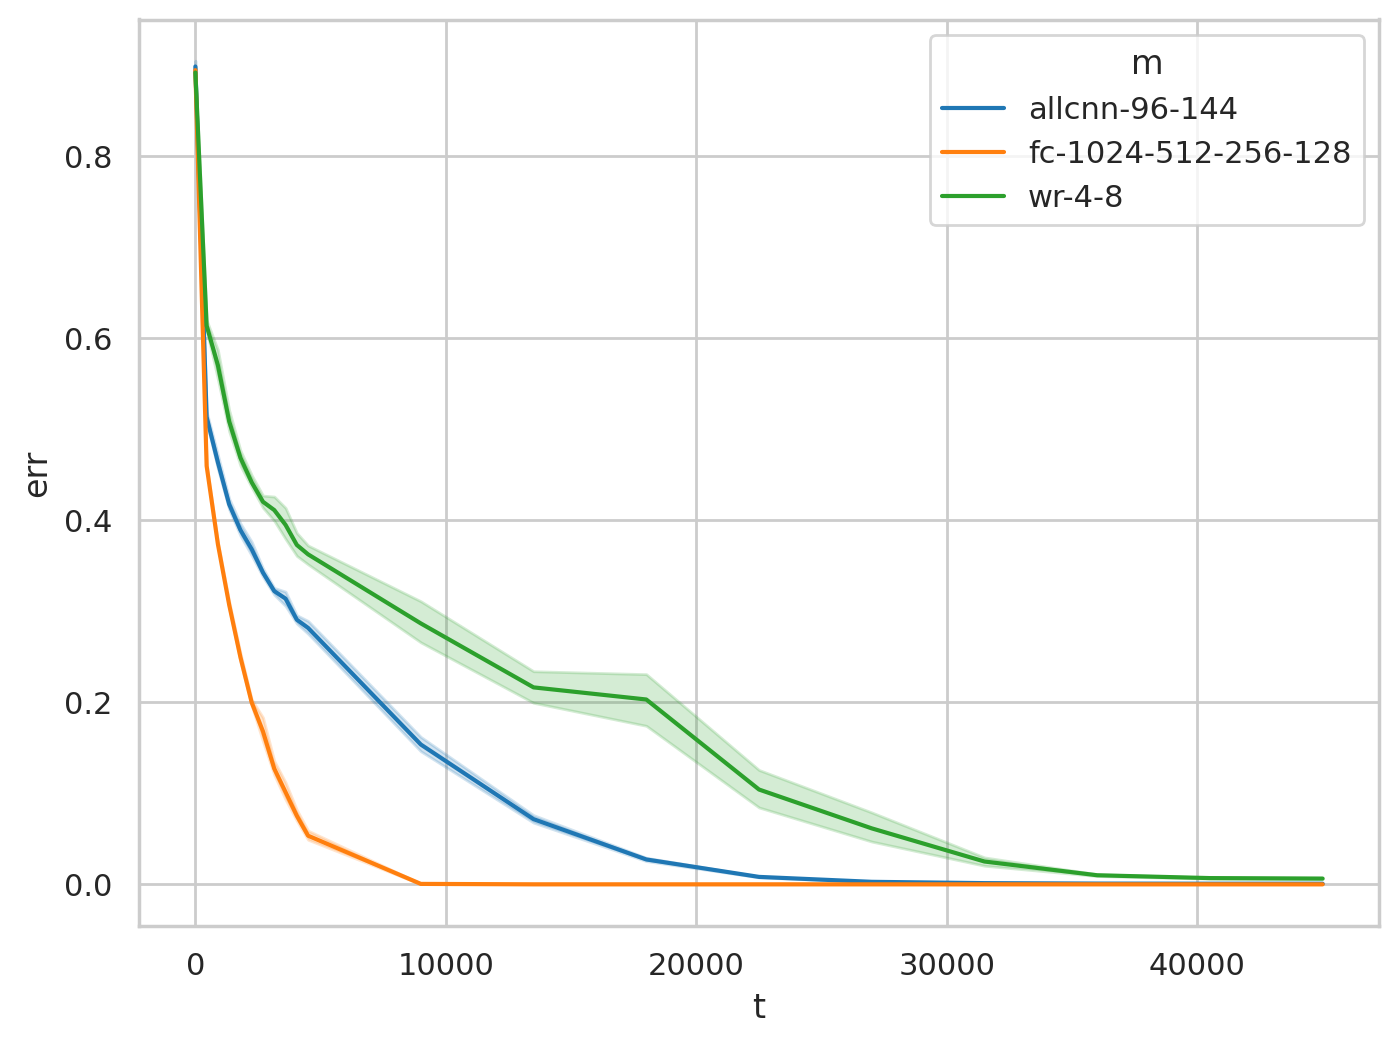

In [109]:
sns.lineplot(data=d_.iloc[get_idx(d_, f" bn == True & opt == 'sgd'")],
             x='t', y='err', hue='m')

<AxesSubplot:xlabel='t', ylabel='verr'>

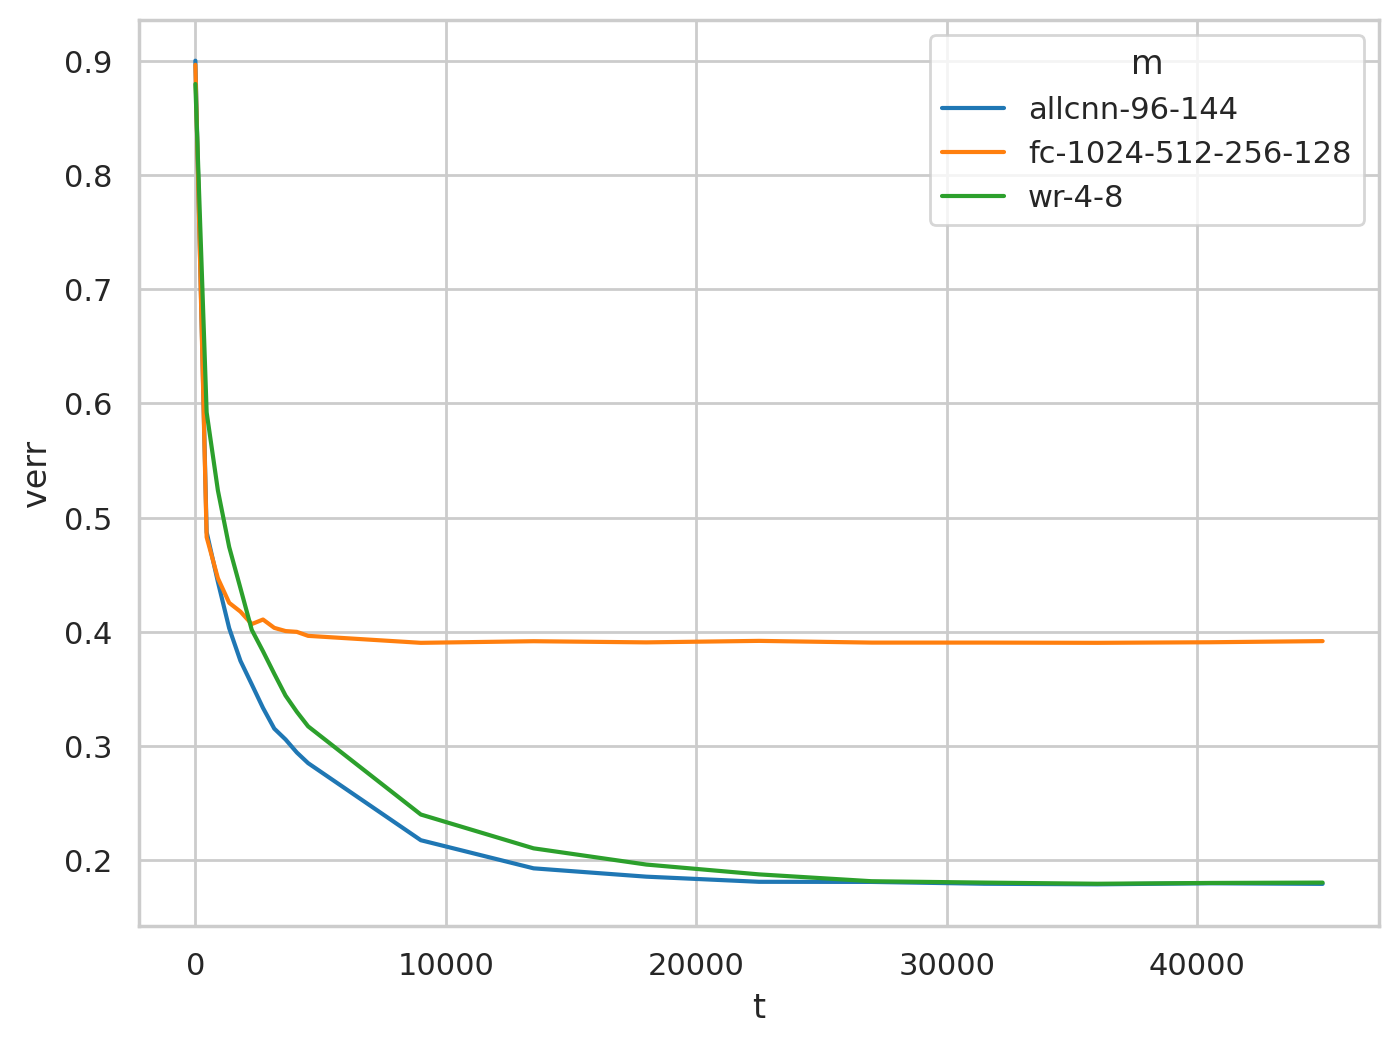

In [110]:
sns.lineplot(data=avg.iloc[get_idx(avg, f" bn == True & opt == 'sgd'")],
             x='t', y='verr', hue='m')

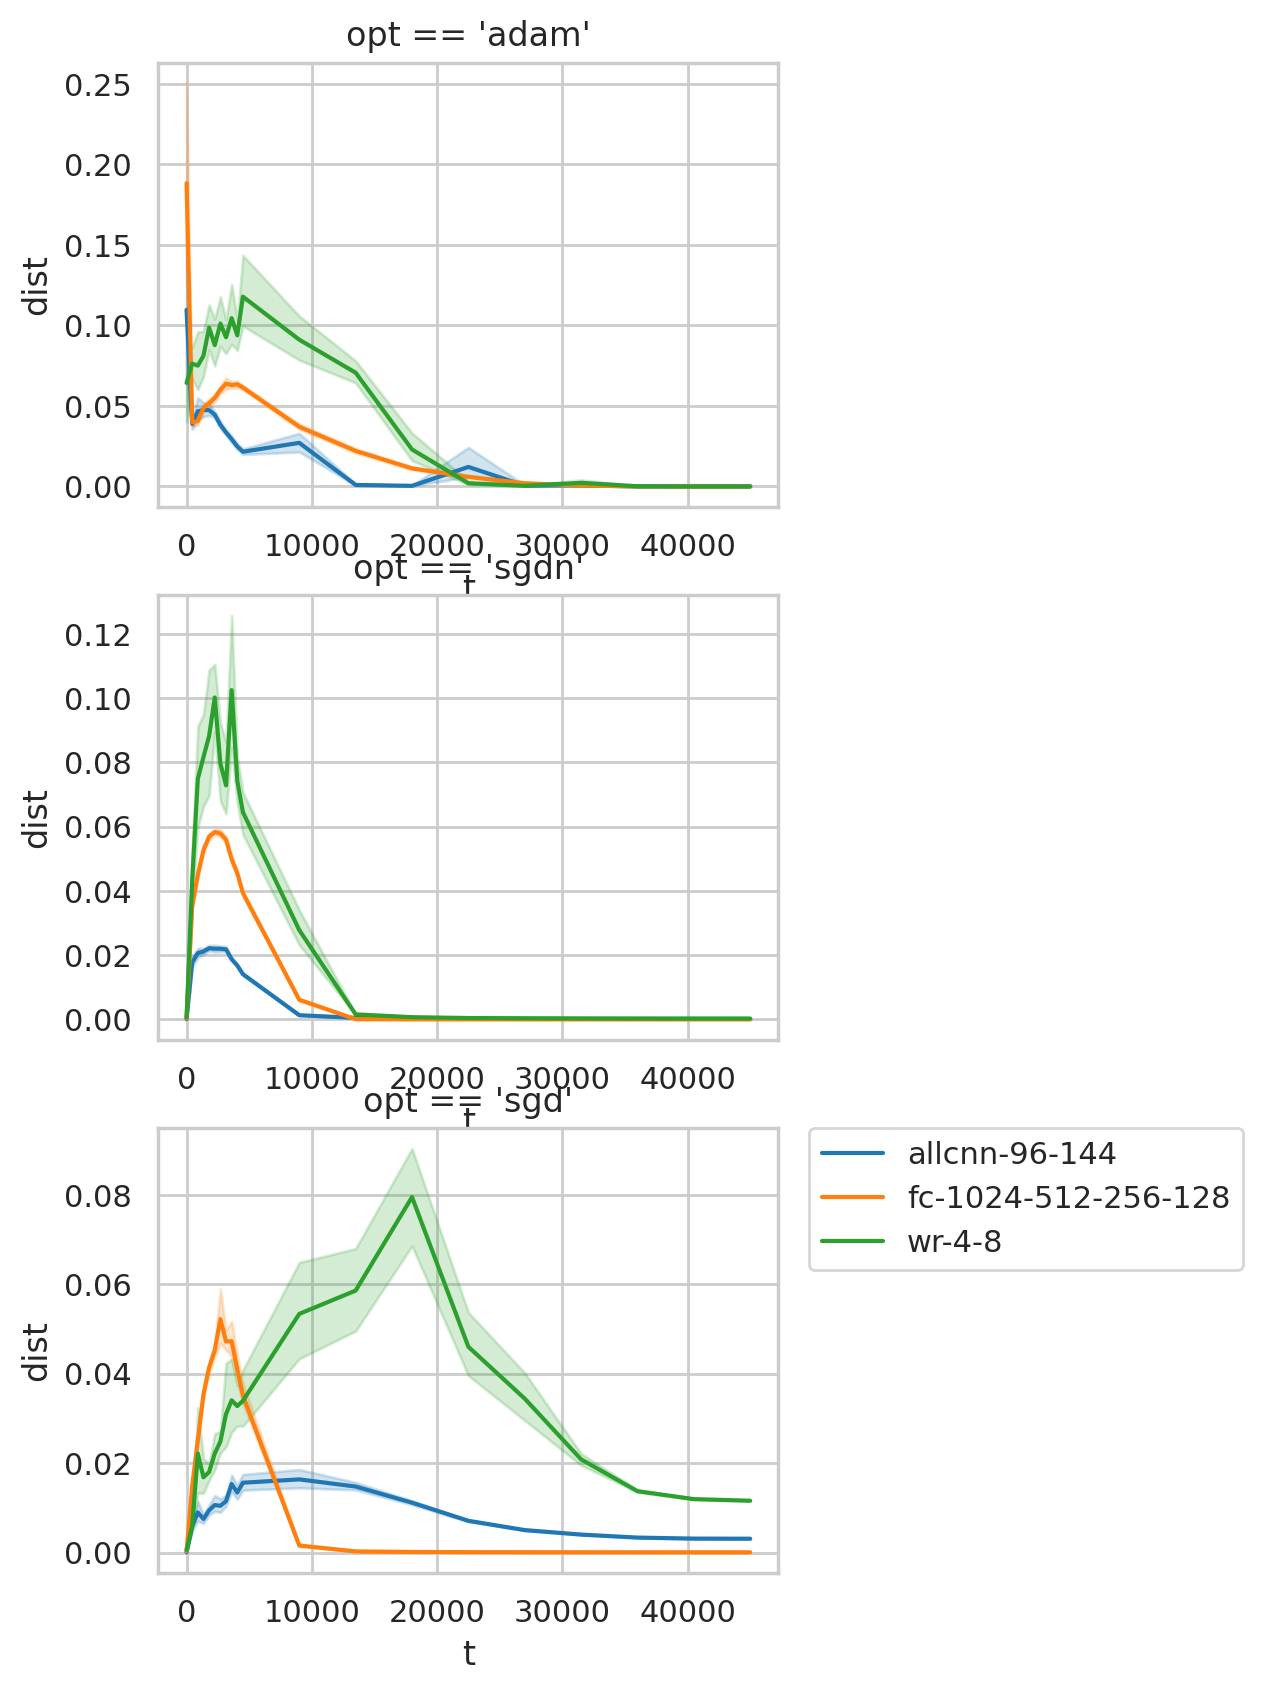

In [26]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
leg = None
for (i,opt) in enumerate(opts):
    if leg:
        leg.remove()
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh' & bn == True & opt == {opt}")],
             x='t', y='dist', hue='m', ax=axes[i])
    axes[i].set_title(f"opt == {opt}")
    leg = axes[i].get_legend()
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


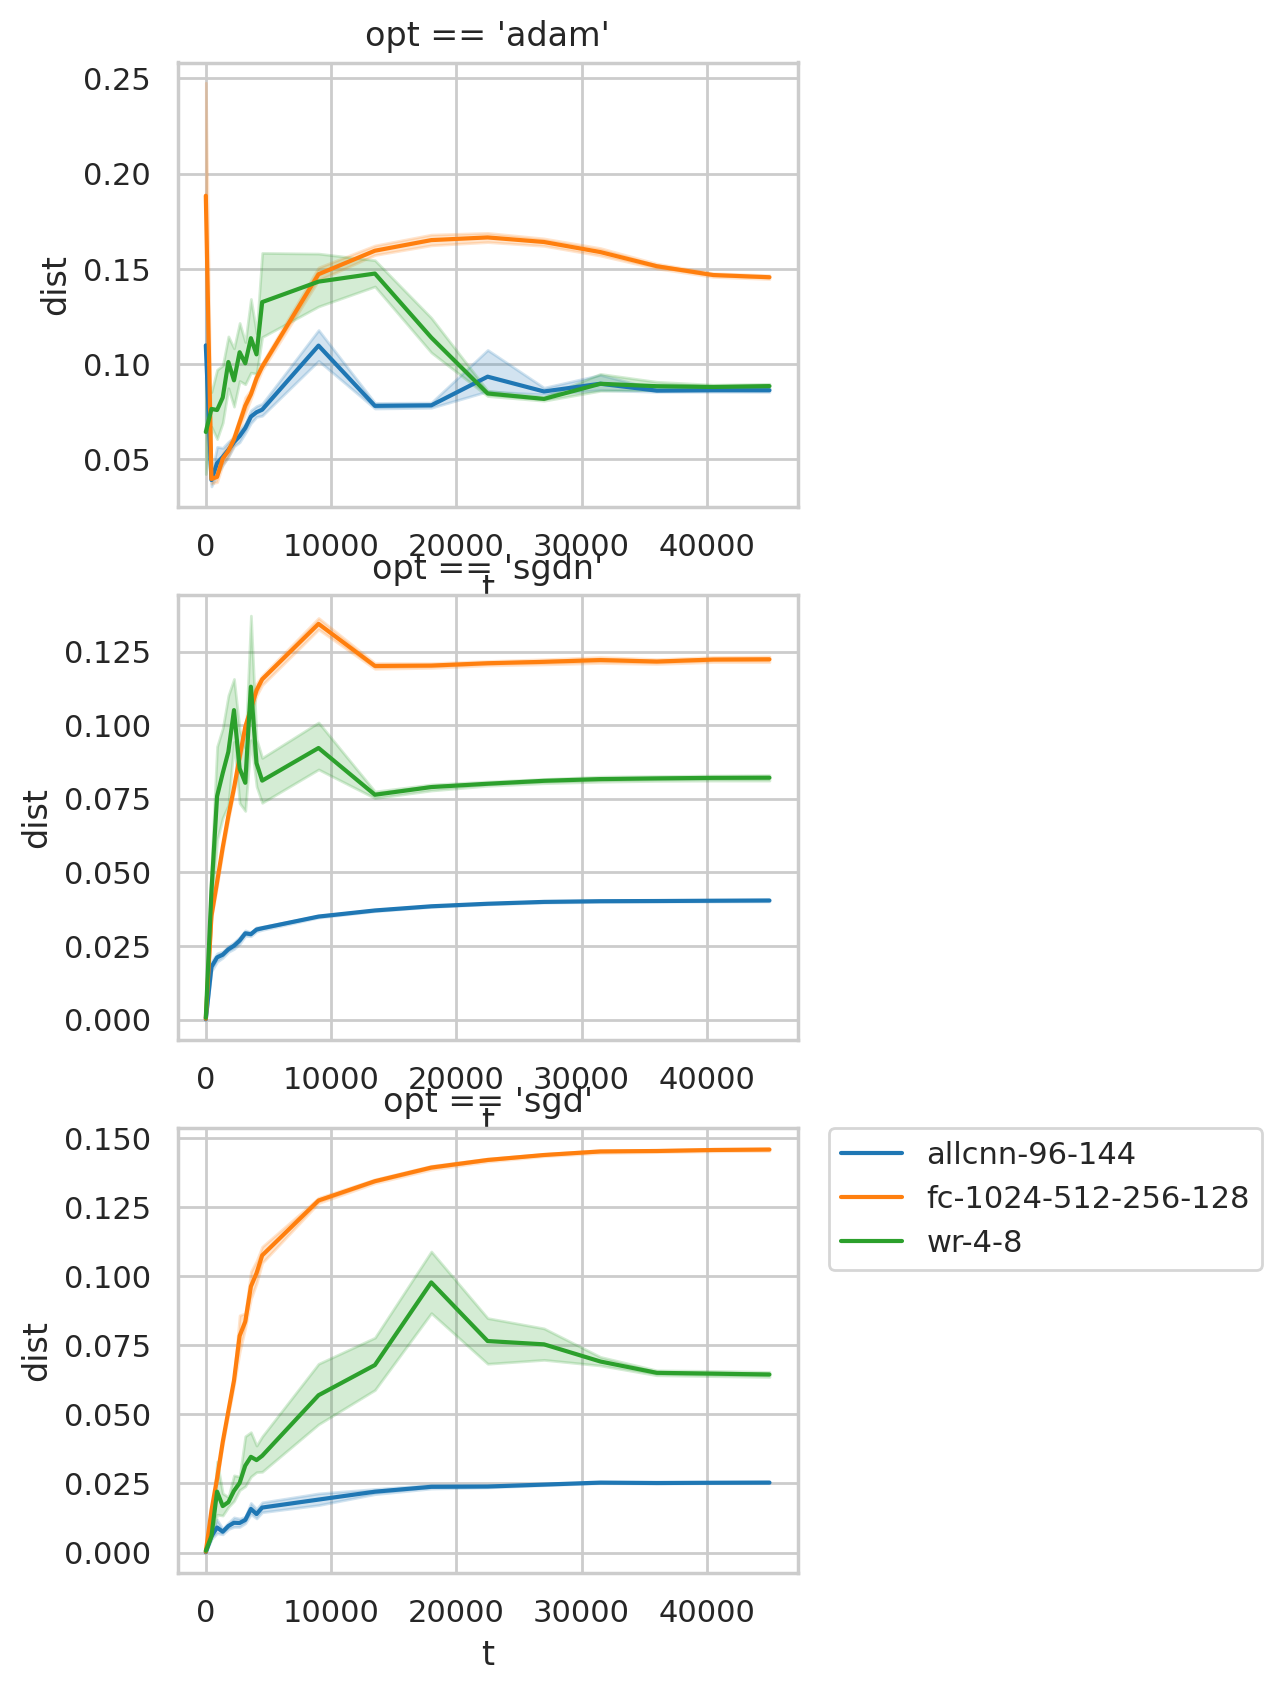

In [27]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
leg = None
for (i,opt) in enumerate(opts):
    if leg:
        leg.remove()
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yvh' & bn == True & opt == {opt}")],
             x='t', y='dist', hue='m', ax=axes[i])
    axes[i].set_title(f"opt == {opt}")
    leg = axes[i].get_legend()
#     axes[i].get_legend().remove()
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


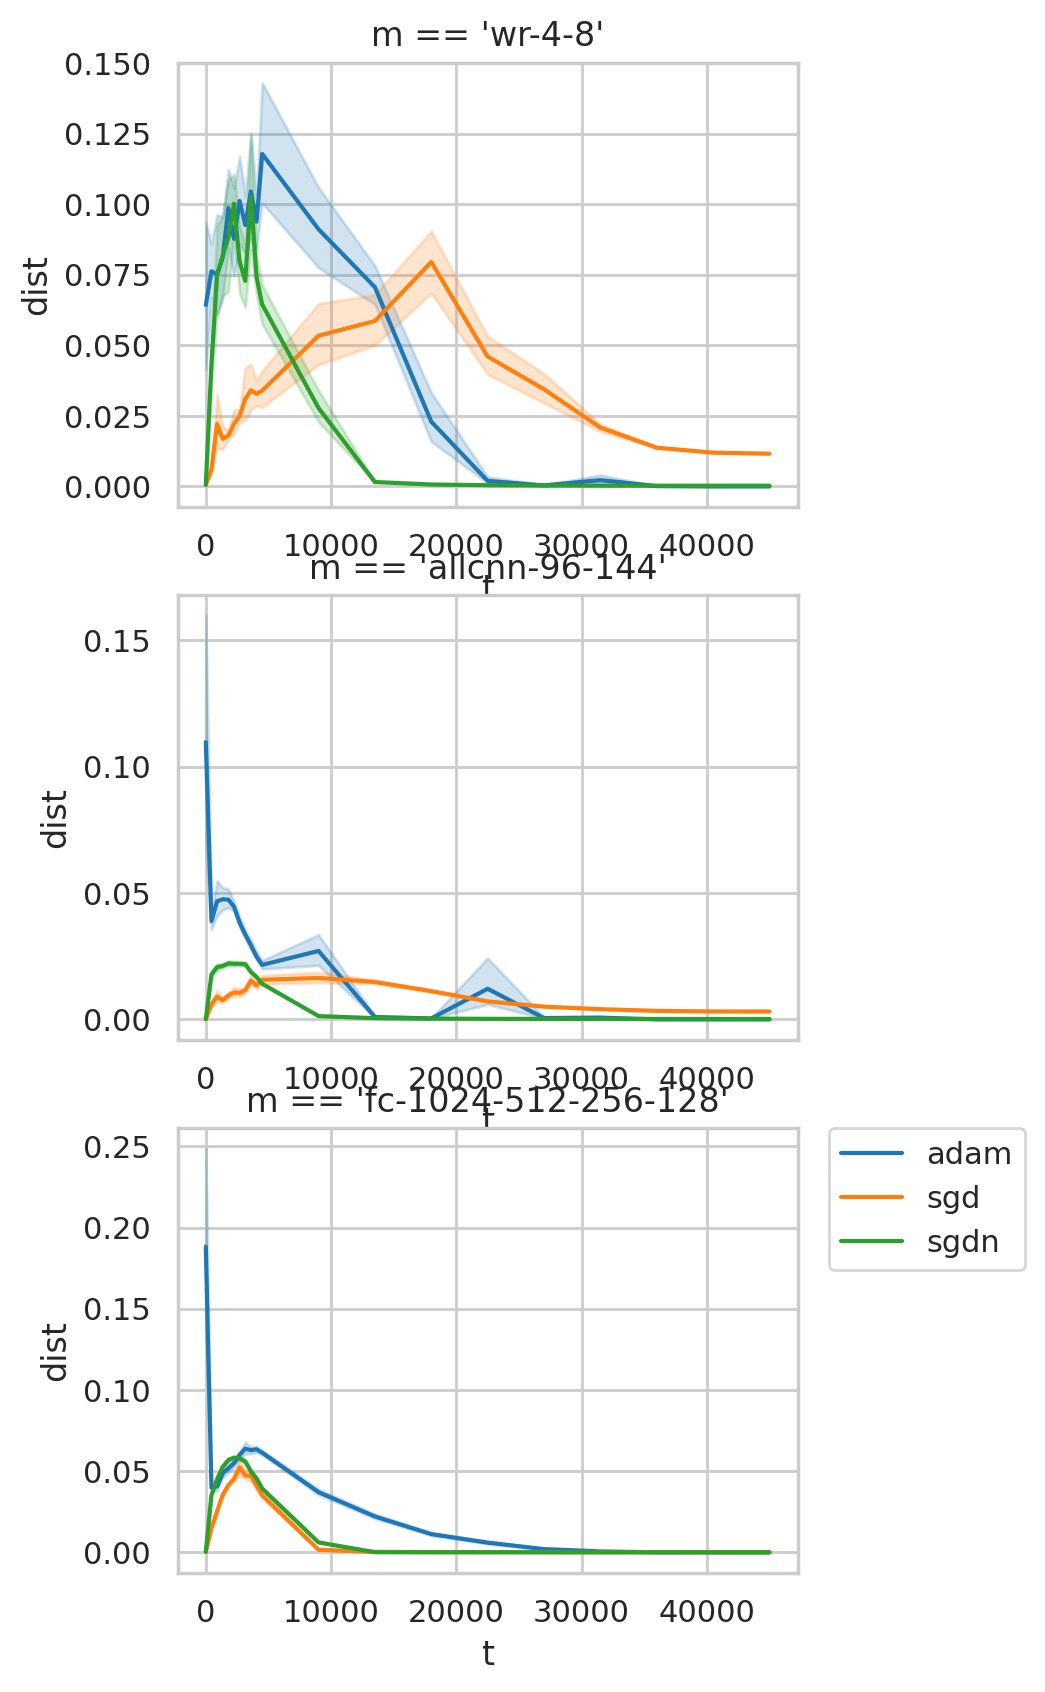

In [29]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
leg = None
for (i,m) in enumerate(models):
    if leg:
        leg.remove()
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh' & bn == True & m == {m}")],
             x='t', y='dist', hue='opt', ax=axes[i])
    axes[i].set_title(f"m == {m}")
    leg = axes[i].get_legend()
#     axes[i].get_legend().remove()
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


<AxesSubplot:xlabel='t', ylabel='dist'>

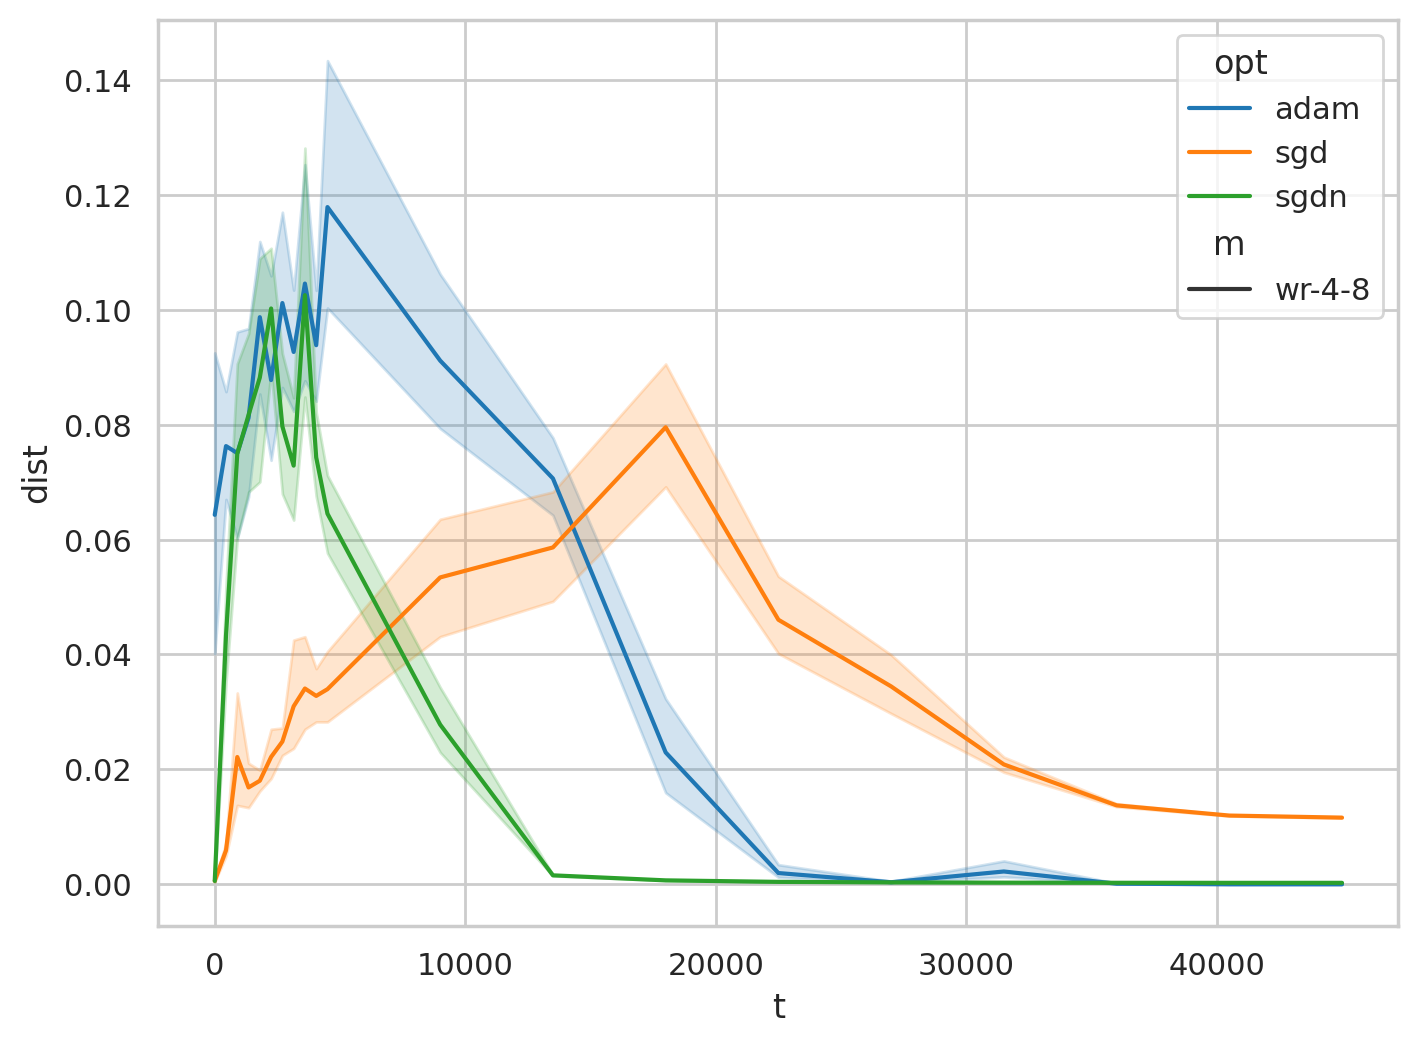

In [141]:
# fig, axes = plt.subplots(3,1, figsize=(4, 10))
# leg = None
# for (i,m) in enumerate(models):
#     if leg:
#         leg.remove()
sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh' & bn == True & m == 'wr-4-8'")],
             x='t', y='dist', hue='opt', style='m')
#     axes[i].set_title(f"m == {m}")
#     leg = axes[i].get_legend()
#     axes[i].get_legend().remove()
# axes[-1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


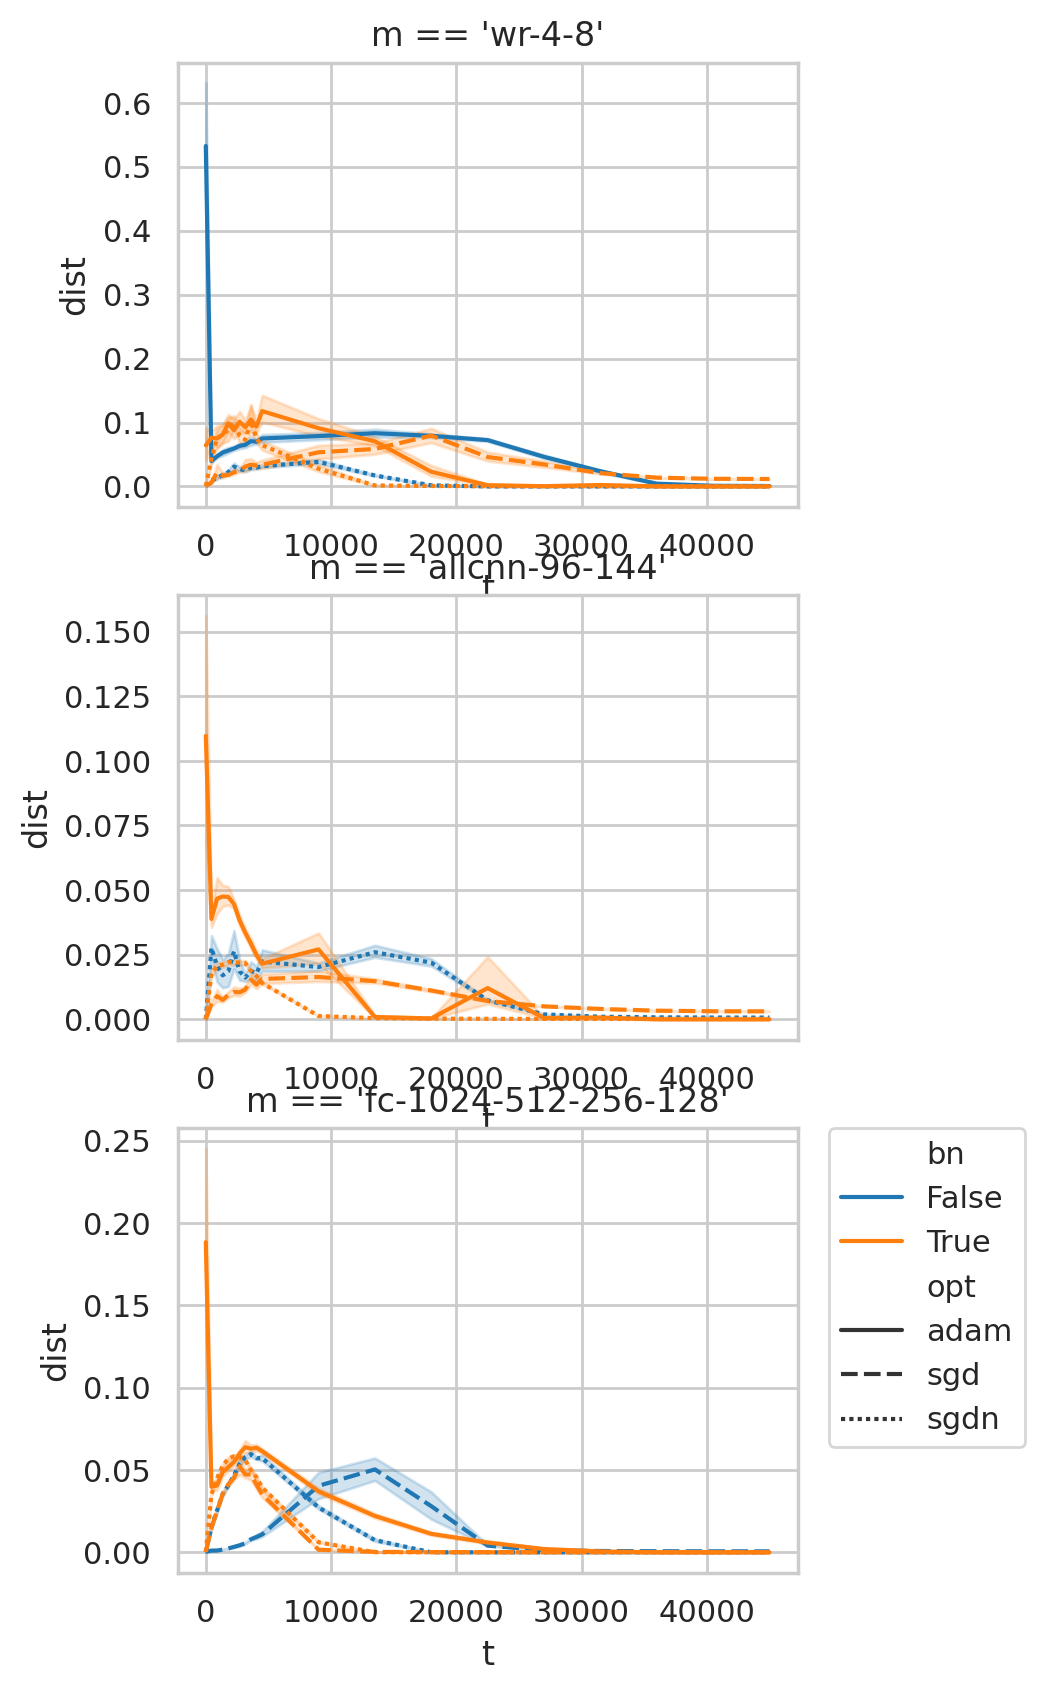

In [73]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
leg = None
for (i,m) in enumerate(models):
    if leg:
        leg.remove()
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh' &  m == {m}")],
             x='t', y='dist', hue='bn', style='opt', ax=axes[i])
    axes[i].set_title(f"m == {m}")
    leg = axes[i].get_legend()
#     axes[i].get_legend().remove()
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
import umap
avg['avg'] = True
d_['avg'] = False
idxs = ['m', 'opt', 'bn', 't', 'yh', 'yvh', 'avg']
allm = pd.concat([avg, d_])[idxs]

### Pairwise Distance

In [30]:
opt = 'adam'
x1 = np.stack(avg.iloc[get_idx(avg,  f"bn == True & opt == '{opt}' & m == 'wr-4-8'")]['yh'])
x2 = np.stack(avg.iloc[get_idx(avg,  f"bn == True & opt == '{opt}' & m == 'allcnn-96-144'")]['yh'])
x3 = np.stack(avg.iloc[get_idx(avg,  f"bn == True & opt == '{opt}' & m == 'fc-1024-512-256-128'")]['yh'])

In [31]:
x1 = th.Tensor(x1).view(20, -1, 10).transpose(0, 1)
x2 = th.Tensor(x2).view(20, -1, 10).transpose(0, 1)
x3 = th.Tensor(x3).view(20, -1, 10).transpose(0, 1)

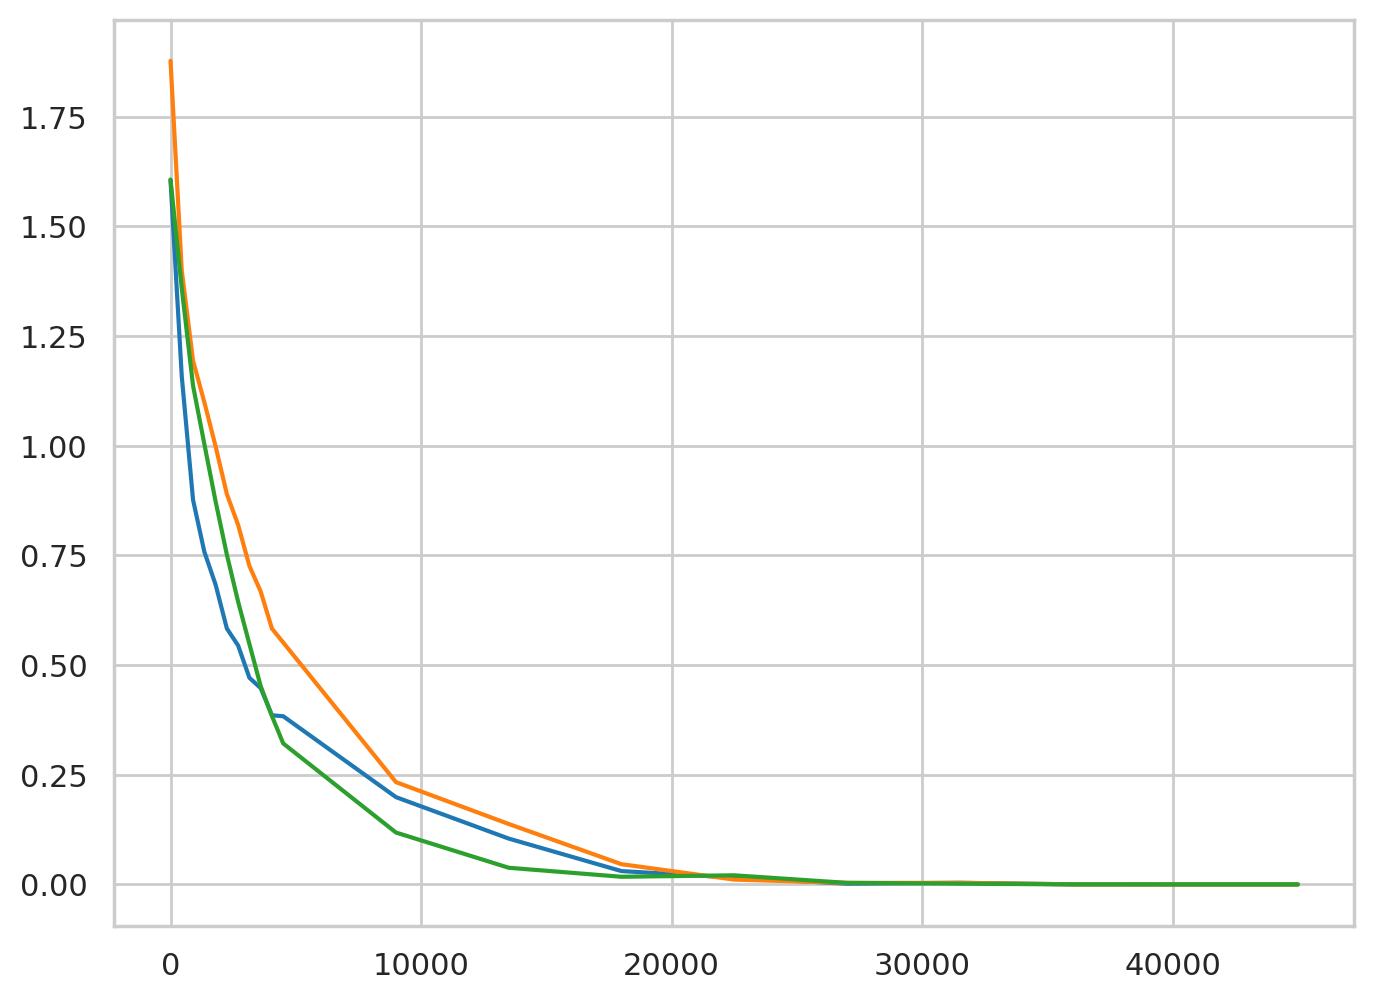

In [33]:
xs = [x1, x2, x3]
for i in range(3):
    for j in range(i+1, 3):
        dist = -th.log(th.bmm(xs[i], xs[j].transpose(1, 2))).mean(0)
        plt.plot(ts, th.diag(dist))

### F-test

In [22]:
models = ["'wr-4-8'", "'allcnn-96-144'", "'fc-1024-512-256-128'"]
opts = ["'adam'", "'sgdn'", "'sgd'"]
bns = [False, True]
mdict = {m.strip("''"):i for (i, m) in enumerate(models)}
odict = {o.strip("''"):i for (i, o) in enumerate(opts)}

In [16]:
def F_test(d, avg, fixed='m', key='yh', verbose=False, distf=th.cdist, ts=range(20), dists=None):
    F = []
    choices = models if fixed == 'm' else opts
    for c in choices:
        for t in ts:
        #     print(t)
            iv = 'opt' if fixed == 'm' else 'm'

            cond = f"bn==True & {fixed} == {c} & t=={t}"
            allm = d.iloc[get_idx(d, cond)]
            levels = len(allm[iv].unique())
            ni = len(allm) // levels

            om = th.Tensor(np.stack(allm[key]).mean(0))
            om = om.view(1, -1, 10).transpose(0, 1)
            
            gm = th.Tensor(np.stack(avg.iloc[get_idx(avg, cond)][key]))
            gm = gm.view(levels, -1, 10).transpose(0, 1)

#             print(om.shape, gm.shape)
#             dms = -th.log(th.bmm(th.sqrt(om), th.sqrt(gm).transpose(1, 2))).mean(0)
            dms = distf(om, gm).mean(0) ** 2
            sb = dms.sum() * ni / (levels-1)
            sw = (dists.iloc[get_idx(dists, f"{cond} & key == '{key}'")]['dist'].values ** 2).sum()/ (len(allm)-levels)
            if verbose:
                print(sb, sw)
            F.append({fixed:c.strip("''"), 'sb': sb.item(), 'sw': sw.item(), 'F':(sb/sw).item(), 't':t})
    return F

#### euclidean-dist

In [20]:
avg, dists = avg_model(d_, groupby=['m', 'opt', 'bn', 't'], probs=True, get_err=True, avg=avg,
                       compute_distance=True, distf=th.cdist, dev='cuda')

<AxesSubplot:xlabel='t', ylabel='F'>

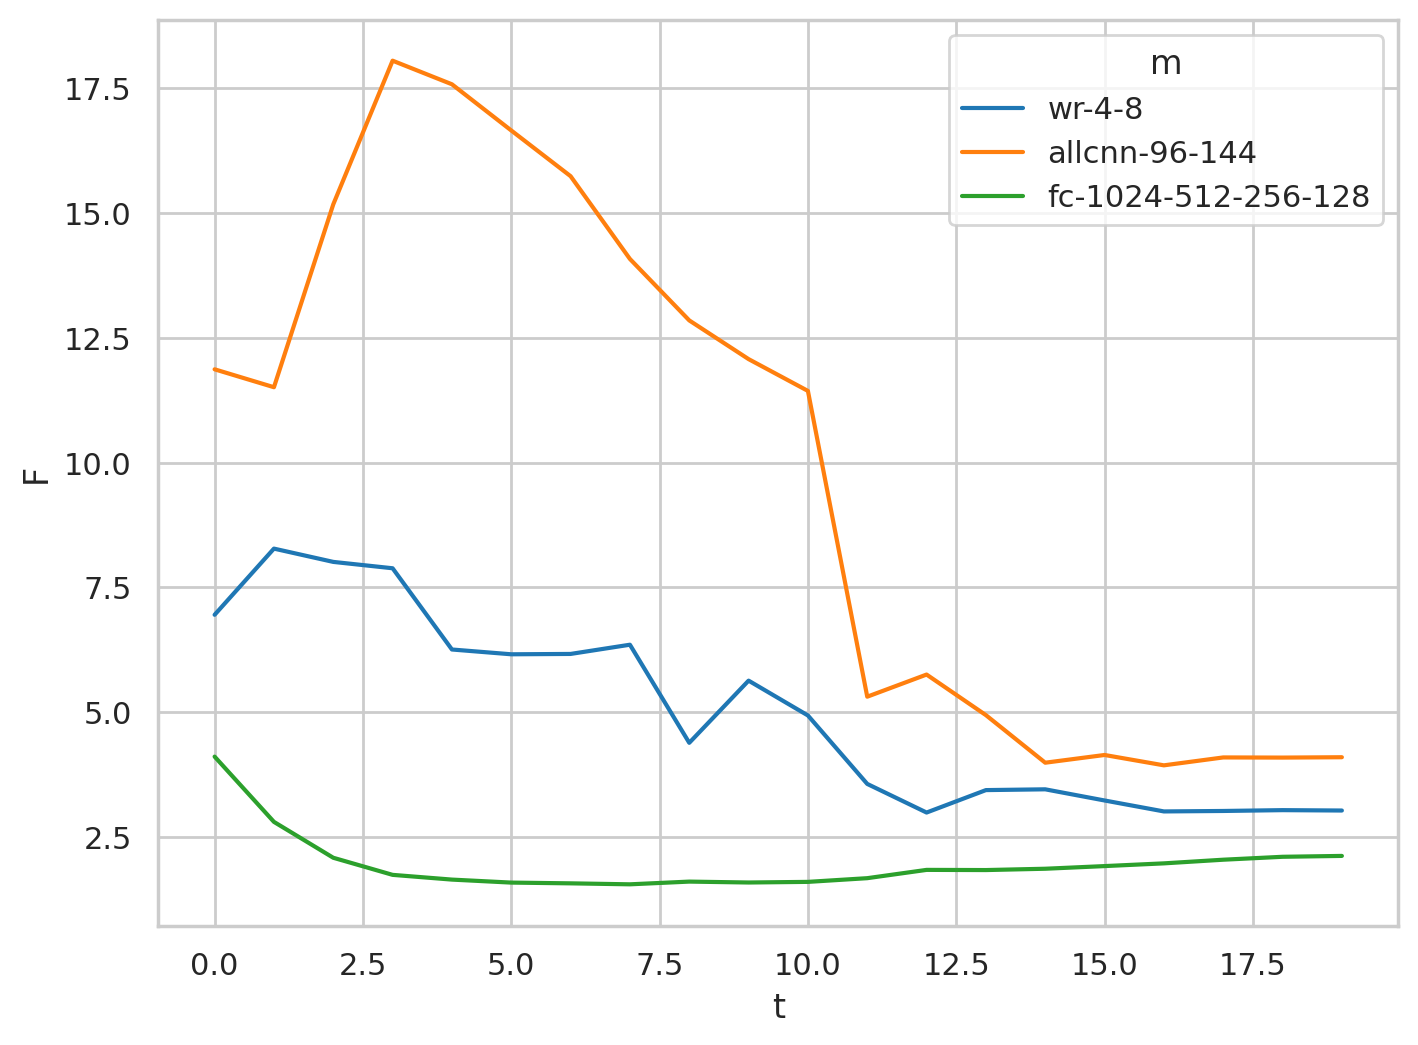

In [23]:
F = F_test(d_,
           avg,
           fixed="m",
           key="yvh",
           distf=th.cdist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["m", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="m")

<AxesSubplot:xlabel='t', ylabel='F'>

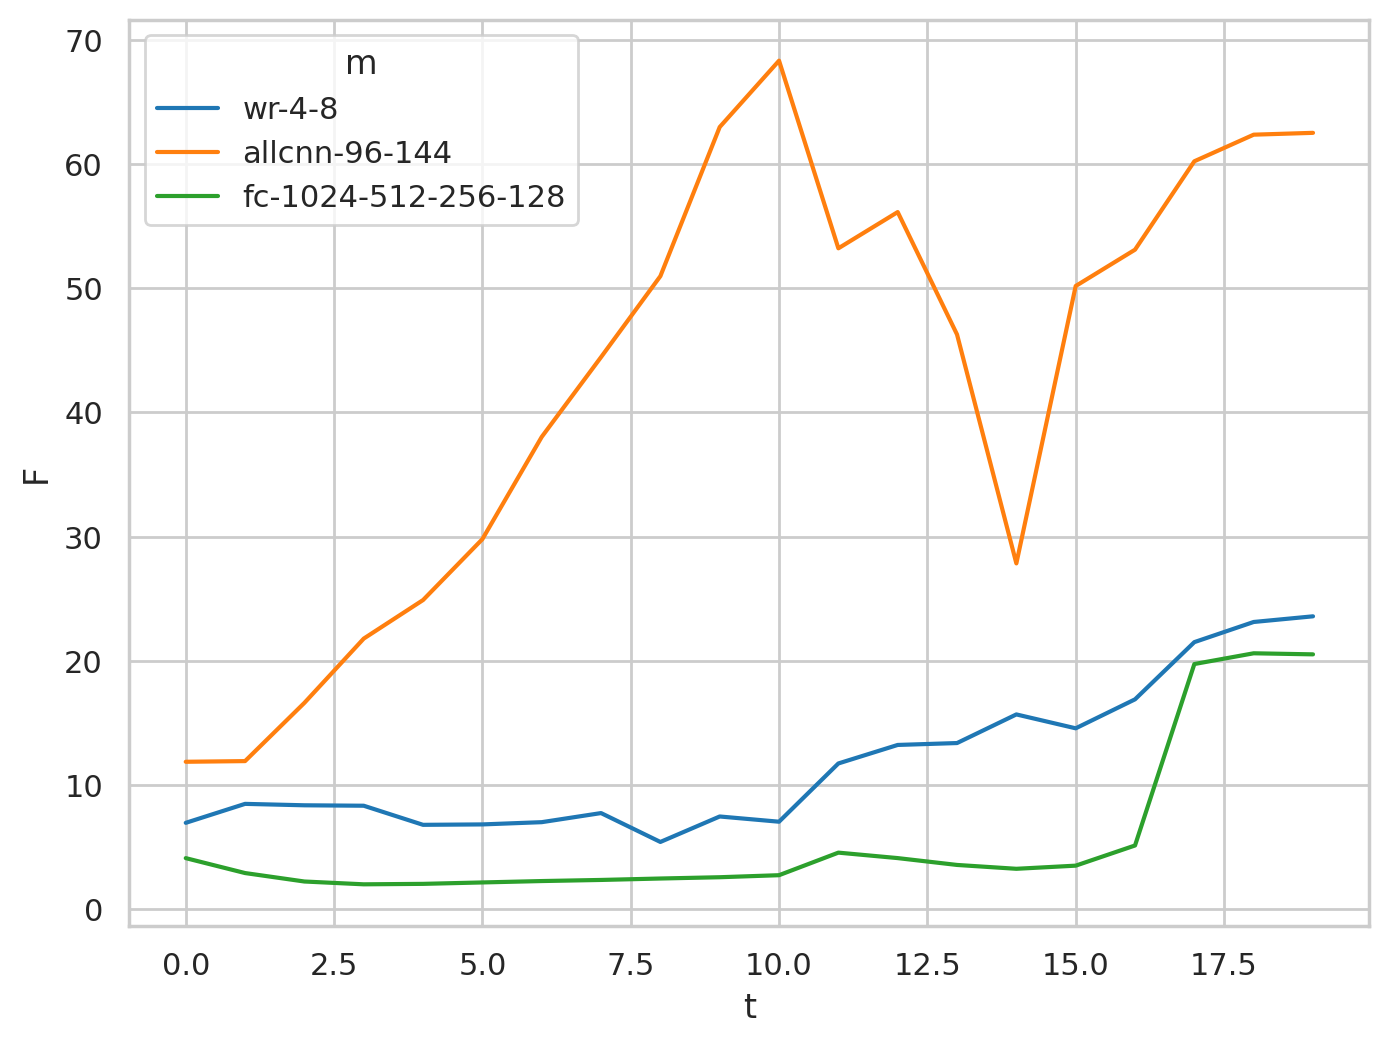

In [24]:
F = F_test(d_,
           avg,
           fixed="m",
           key="yh",
           distf=th.cdist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["m", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="m")

<AxesSubplot:xlabel='t', ylabel='F'>

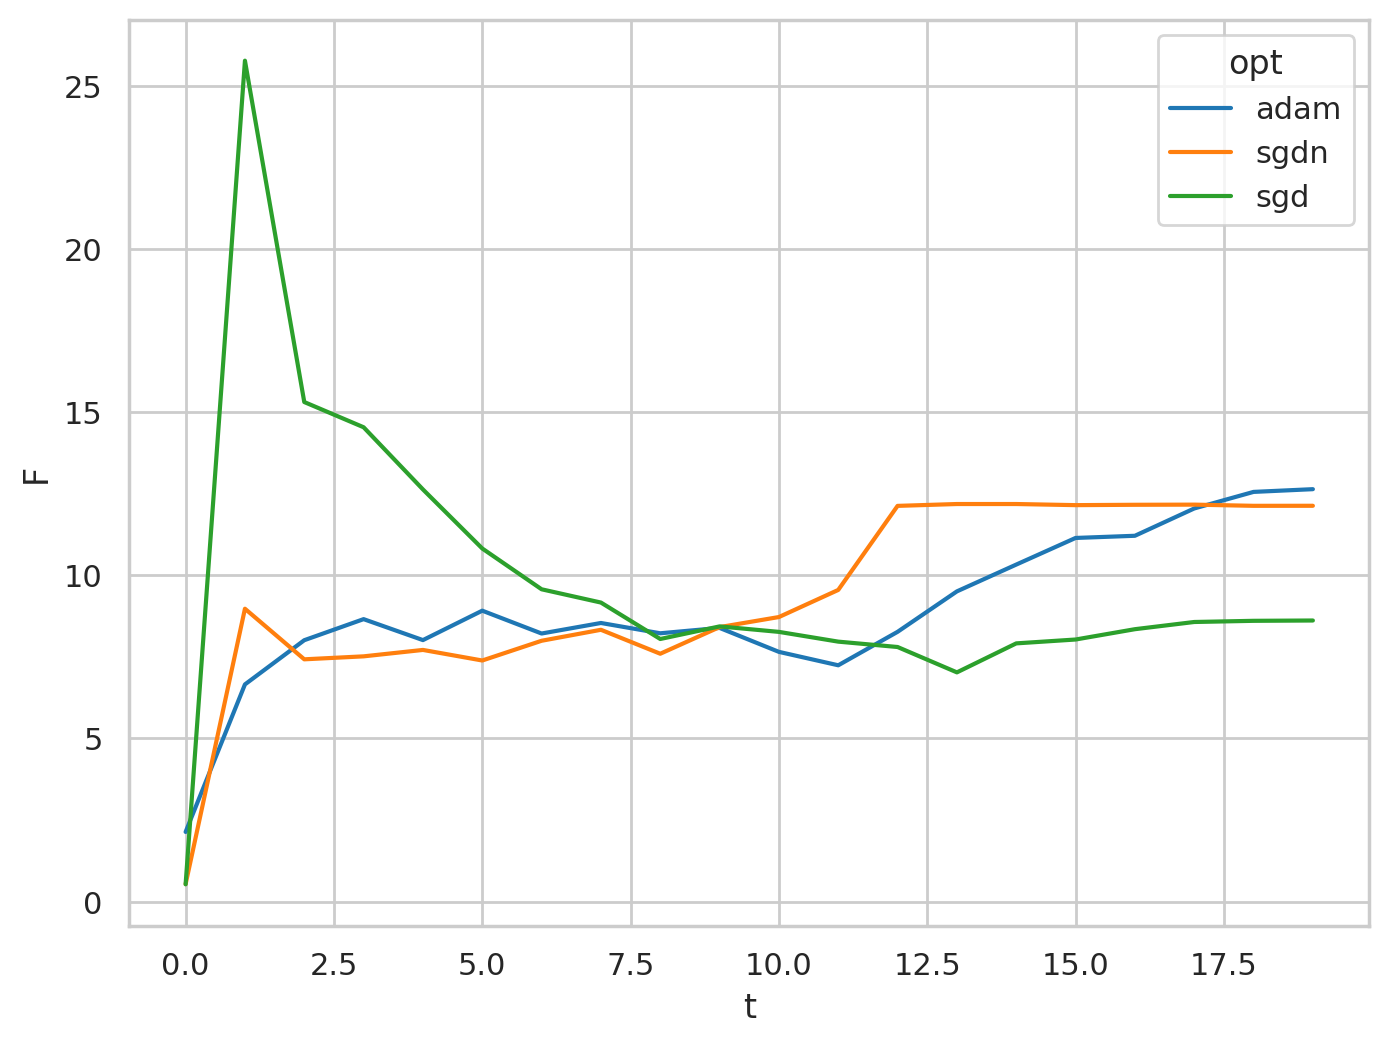

In [26]:
F = F_test(d_,
           avg,
           fixed="opt",
           key="yvh",
           distf=th.cdist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["opt", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="opt")

<AxesSubplot:xlabel='t', ylabel='F'>

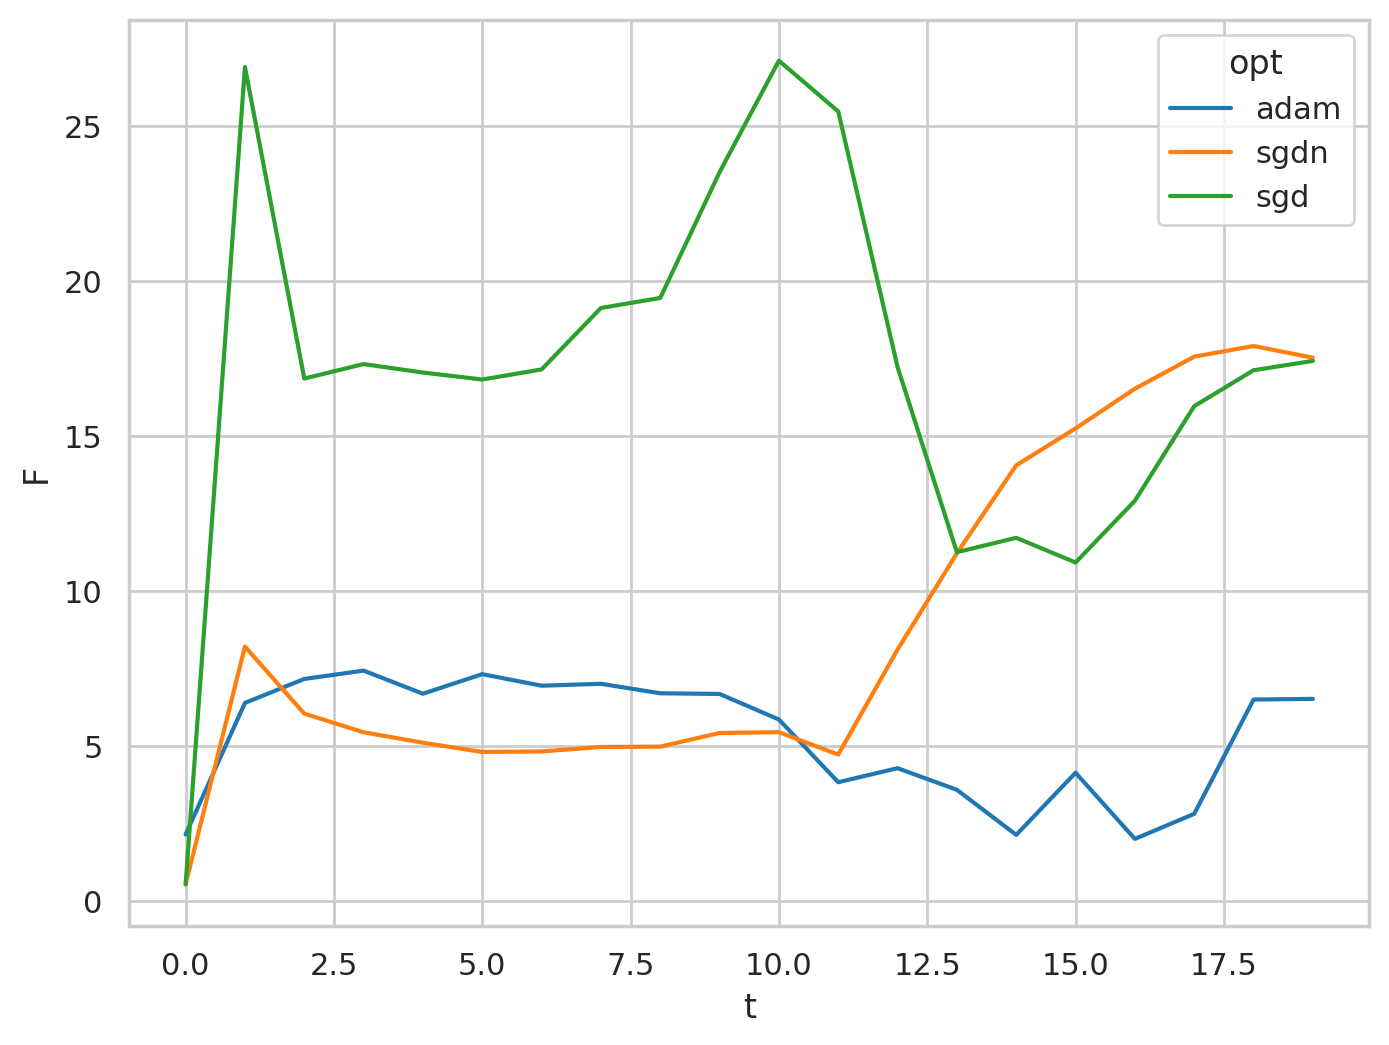

In [27]:
F = F_test(d_,
           avg,
           fixed="opt",
           key="yh",
           distf=th.cdist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["opt", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="opt")

#### bhat-dist

In [34]:
bdist = lambda x1, x2: -th.log(th.bmm(th.sqrt(x1), th.sqrt(x2).transpose(1, 2)))
avg, dists = avg_model(d_, groupby=['m', 'opt', 'bn', 't'], probs=True, get_err=True, avg=avg,
                       compute_distance=True, distf=bdist, dev='cuda')

<AxesSubplot:xlabel='t', ylabel='F'>

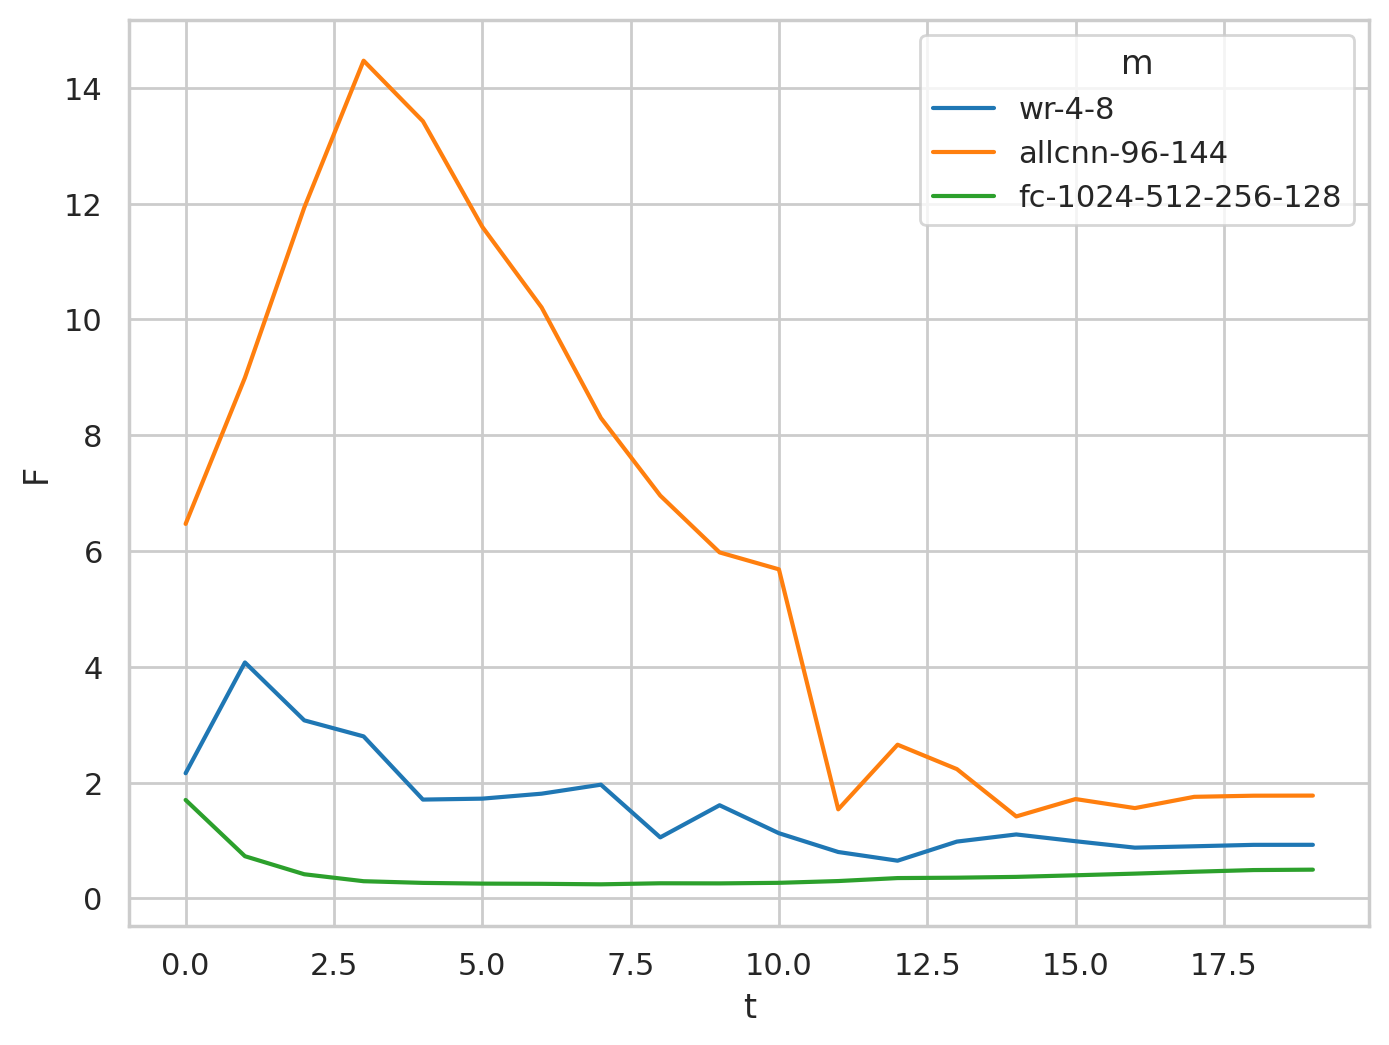

In [36]:
F = F_test(d_,
           avg,
           fixed="m",
           key="yvh",
           distf=bdist,
           dists=dists)
df = pd.DataFrame(F, columns=["m", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="m")

<AxesSubplot:xlabel='t', ylabel='F'>

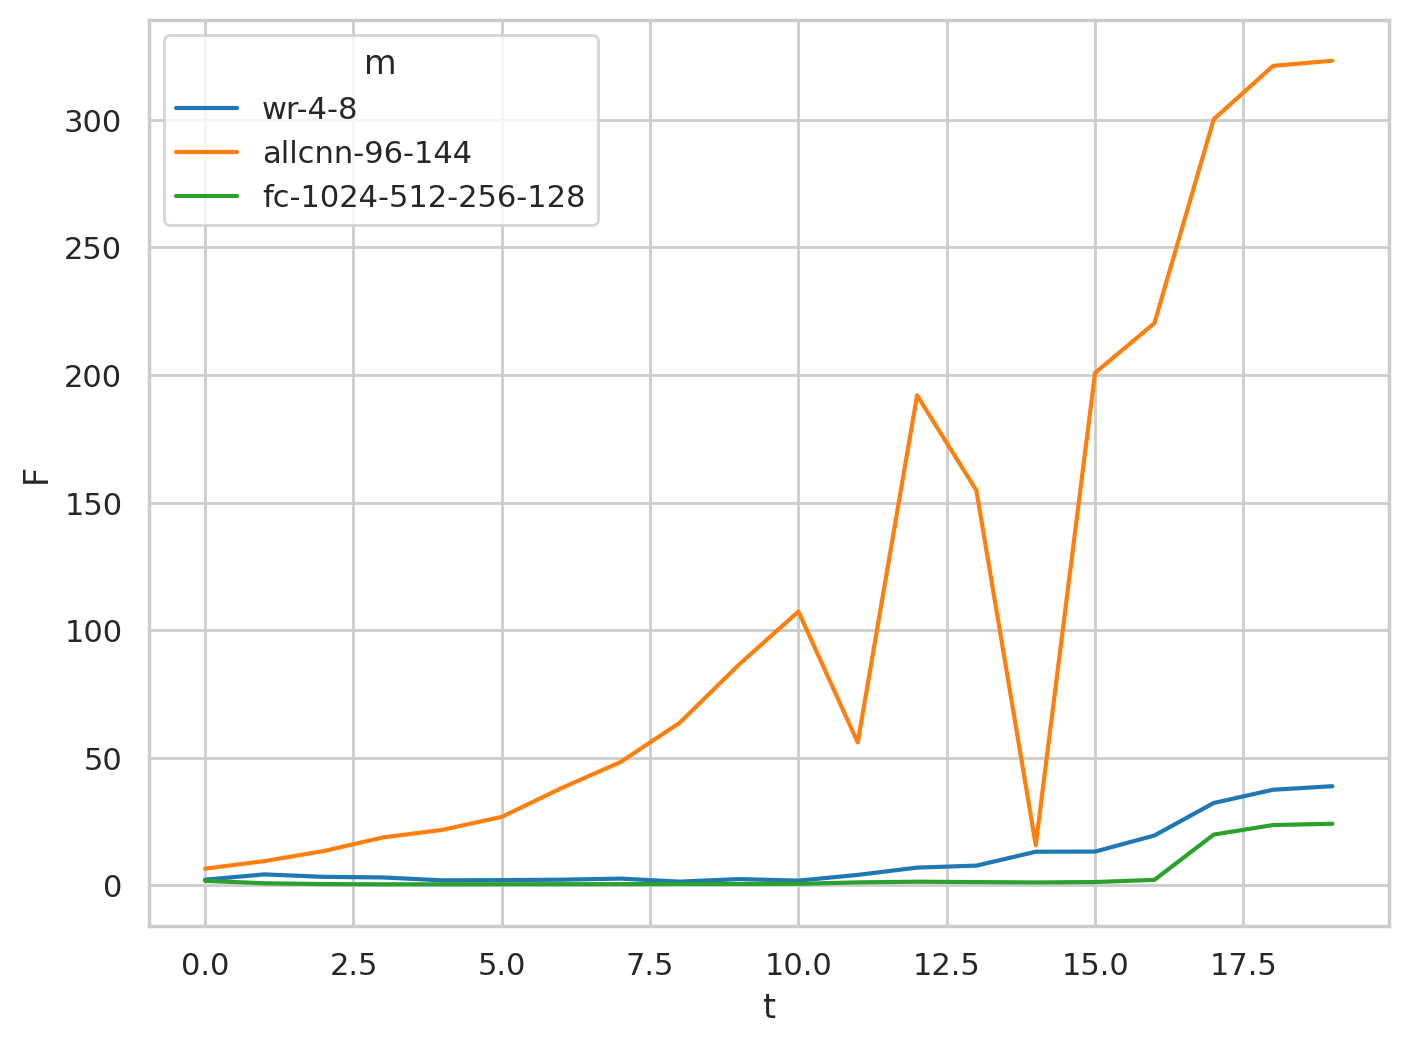

In [37]:
F = F_test(d_,
           avg,
           fixed="m",
           key="yh",
           distf=bdist,
           dists=dists)
df = pd.DataFrame(F, columns=["m", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="m")

<AxesSubplot:xlabel='t', ylabel='F'>

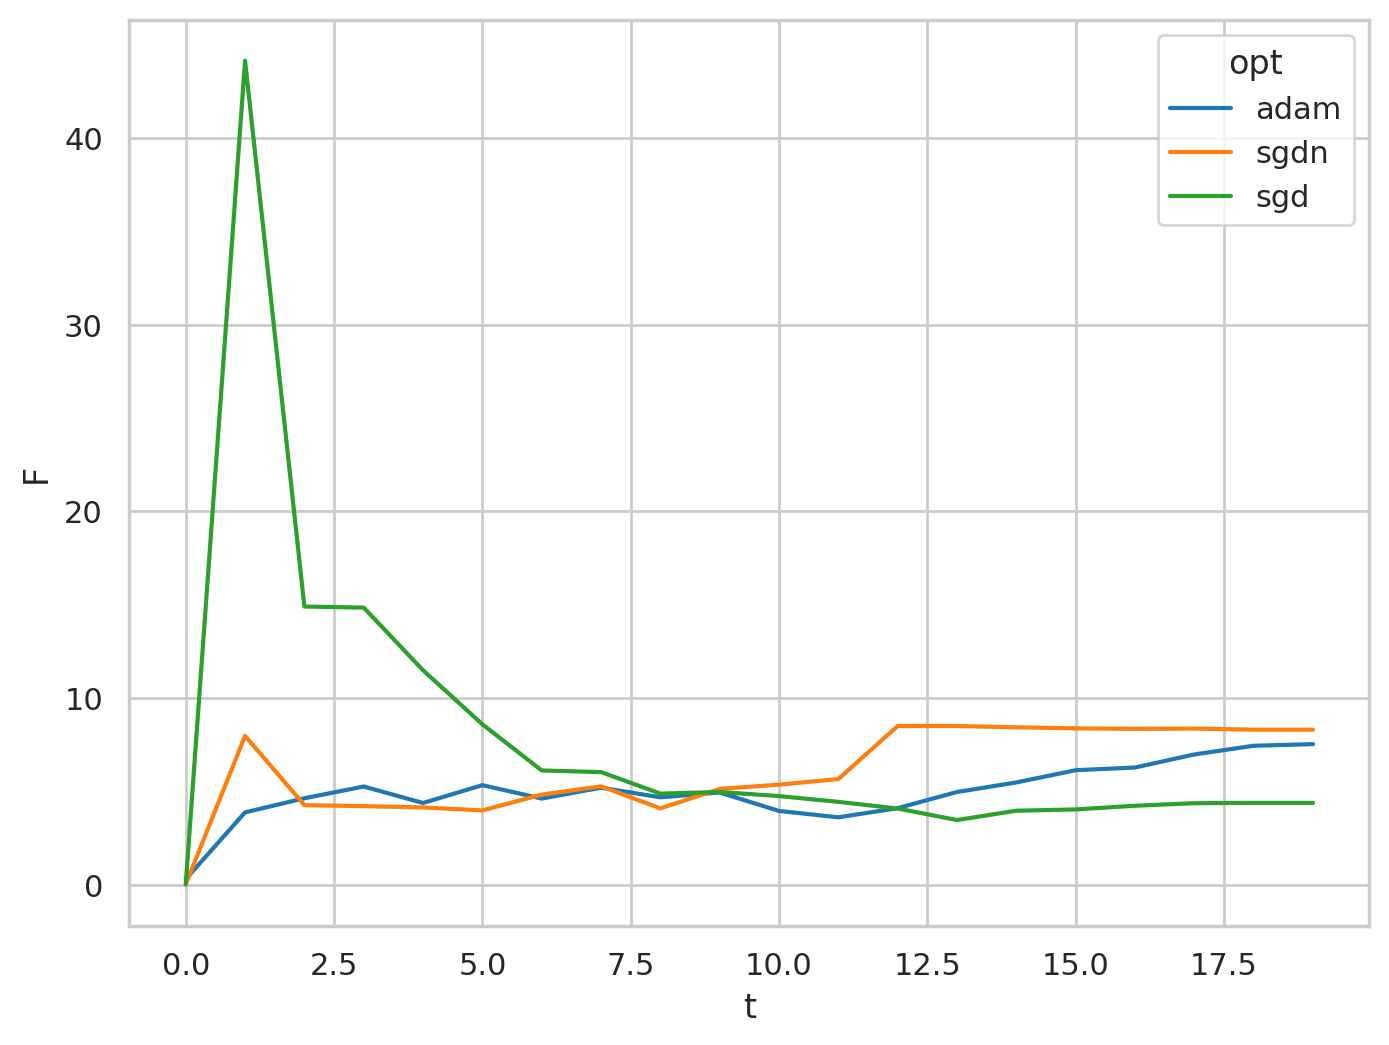

In [38]:
F = F_test(d_,
           avg,
           fixed="opt",
           key="yvh",
           distf=bdist,
           dists=dists)
df = pd.DataFrame(F, columns=["opt", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="opt")

<AxesSubplot:xlabel='t', ylabel='F'>

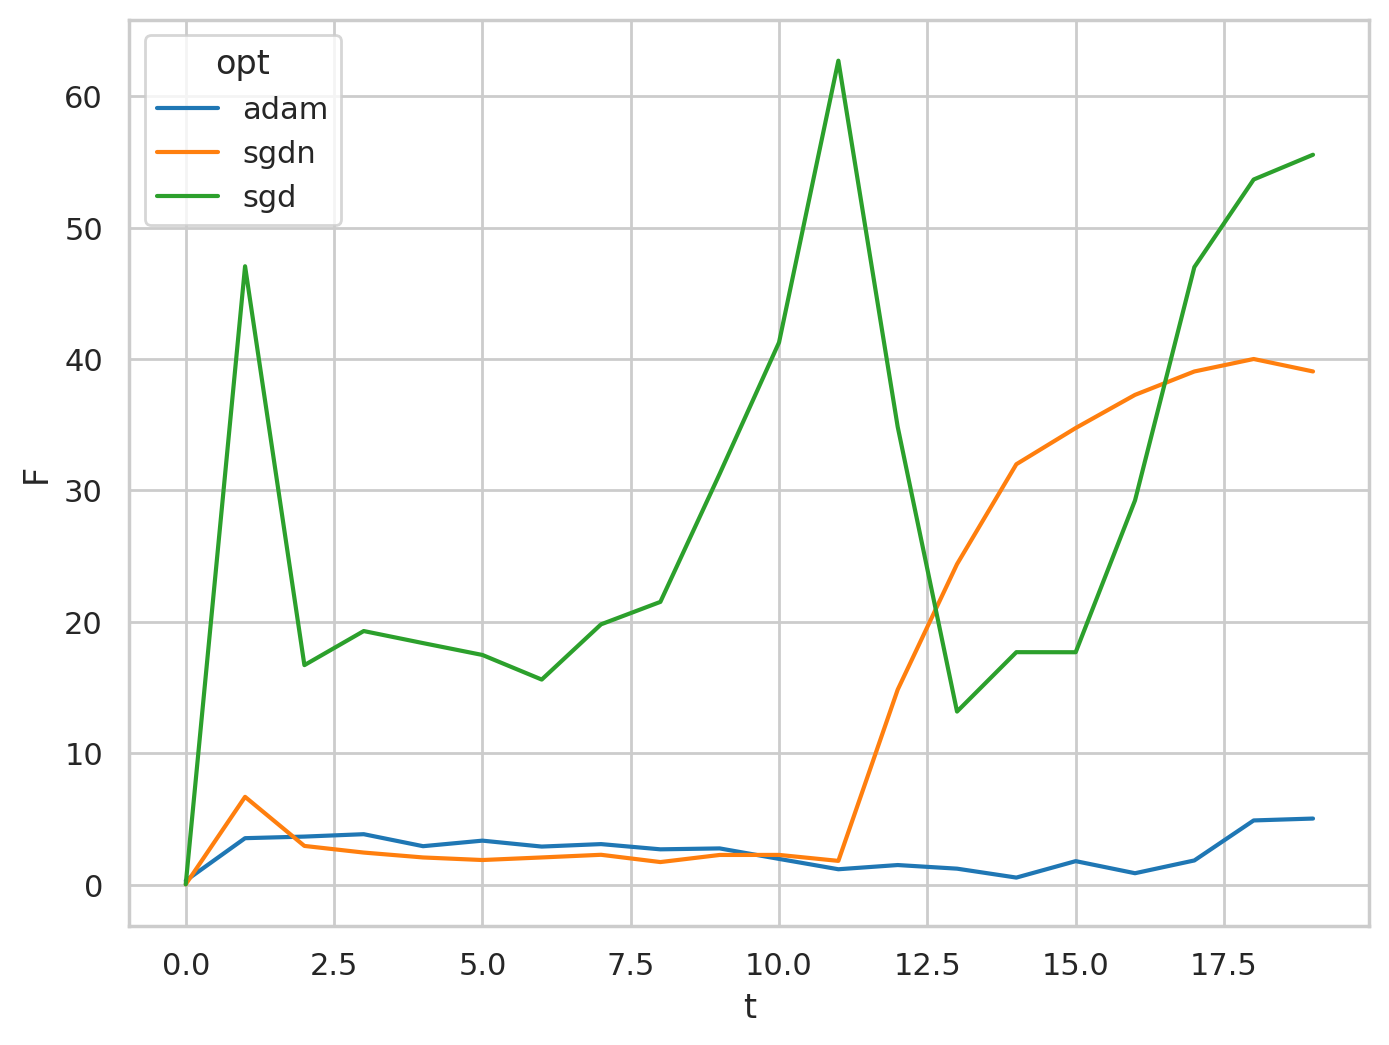

In [39]:
F = F_test(d_,
           avg,
           fixed="opt",
           key="yh",
           distf=bdist,
           dists=dists)
df = pd.DataFrame(F, columns=["opt", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="opt")

### Trajectory on single sample

In [5]:
from embed import *

In [12]:
d_ = drop_untrained(d).reset_index()

In [15]:
mistakes = set(np.arange(50000))
for t in range(20):
    errs = np.stack(d_.iloc[get_idx(d_, f"t == {t}")]['e'])
    mistakes.intersection_update(np.where(errs.sum(0)>0)[0])

In [17]:
idx = ['seed', 'm', 'opt', 't', 'err', 'verr', 'favg', 'vfavg', 'bn']
fn = f'yh_new_subset'
embed(d, fn=fn, ss=list(mistakes), probs=False, key='yh', idx=idx, force=True)

torch.Size([3600, 1404, 10])
chunks:  600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:15<00:00, 29.73it/s]


Saving w
Projecting


In [16]:
len(mistakes)

1404